##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Load text

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/text"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates two ways to load and preprocess text.

- First, you will use Keras utilities and preprocessing layers. These include `tf.keras.utils.text_dataset_from_directory` to turn data into a `tf.data.Dataset` and `tf.keras.layers.TextVectorization` for data standardization, tokenization, and vectorization. If you are new to TensorFlow, you should start with these.
- Then, you will use lower-level utilities like `tf.data.TextLineDataset` to load text files, `tf.lookup` for custom in-model lookup tables, and [TensorFlow Text](https://www.tensorflow.org/text) APIs, such as `text.UnicodeScriptTokenizer` and `text.case_fold_utf8`, to preprocess the data for finer-grain control.

In [2]:
!pip install "tensorflow-text==2.13.*"

ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.13.* (from versions: 2.4.0rc0, 2.4.0rc1, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.5.0, 2.6.0rc0, 2.6.0, 2.7.0rc0, 2.7.0rc1, 2.7.3, 2.8.0rc0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0, 2.10.0b2, 2.10.0rc0, 2.10.0)
ERROR: No matching distribution found for tensorflow-text==2.13.*


In [4]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

c:\Users\usuar\Desktop\The_Bridge\ONLINE_DS_THEBRIDGE_jacobo\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1: Predict the tag for a Stack Overflow question

As a first example, you will download a dataset of programming questions from Stack Overflow. Each question (_"How do I sort a dictionary by value?"_) is labeled with exactly one tag (`Python`, `CSharp`, `JavaScript`, or `Java`). Your task is to develop a model that predicts the tag for a question. This is an example of multi-class classification—an important and widely applicable kind of machine learning problem.

To implement this task, you'll start with the simplest tools:

* `keras.utils.text_datasaet_from_directory`: for loading text-file examples.
* `keras.layers.TextVectorization`: for converting strings to token indices.


### Download and explore the dataset

Begin by downloading the Stack Overflow dataset using `tf.keras.utils.get_file`, and exploring the directory structure:

In [5]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

dataset_dir = pathlib.Path(dataset_dir).parent

6053168/6053168 [==============================] - 1s 0us/step


In [6]:
list(dataset_dir.iterdir())

[WindowsPath('/tmp/.keras/README.md'),
 WindowsPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 WindowsPath('/tmp/.keras/test'),
 WindowsPath('/tmp/.keras/train')]

In [7]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[WindowsPath('/tmp/.keras/train/csharp'),
 WindowsPath('/tmp/.keras/train/java'),
 WindowsPath('/tmp/.keras/train/javascript'),
 WindowsPath('/tmp/.keras/train/python')]

The `train/csharp`, `train/java`, `train/python` and `train/javascript` directories contain many text files, each of which is a Stack Overflow question.

Print an example file and inspect the data:

In [8]:
sample_file = train_dir/'python/1755.txt'

with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



### Load the dataset

Next, you will load the data off-disk and prepare it into a format suitable for training. To do so, you will use the `tf.keras.utils.text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. If you're new to `tf.data`, it's a powerful collection of tools for building input pipelines. (Learn more in the [tf.data: Build TensorFlow input pipelines](../../guide/data.ipynb) guide.)

The `tf.keras.utils.text_dataset_from_directory` API expects a directory structure as follows:

```
train/
...csharp/
......1.txt
......2.txt
...java/
......1.txt
......2.txt
...javascript/
......1.txt
......2.txt
...python/
......1.txt
......2.txt
```

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [training](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The Stack Overflow dataset has already been divided into training and test sets, but it lacks a validation set.

Create a validation set using an 80:20 split of the training data by using `tf.keras.utils.text_dataset_from_directory` with `validation_split` set to `0.2` (i.e. 20%):

In [9]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As the previous cell output suggests, there are 8,000 examples in the training folder, of which you will use 80% (or 6,400) for training. You will learn in a moment that you can train a model by passing a `tf.data.Dataset` directly to `Model.fit`.

First, iterate over the dataset and print out a few examples, to get a feel for the data.

Note: To increase the difficulty of the classification problem, the dataset author replaced occurrences of the words *Python*, *CSharp*, *JavaScript*, or *Java* in the programming question with the word *blank*.

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

The labels are `0`, `1`, `2` or `3`. To check which of these correspond to which string label, you can inspect the `class_names` property on the dataset:


In [11]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Next, you will create a validation and a test set using `tf.keras.utils.text_dataset_from_directory`. You will use the remaining 1,600 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments of `tf.keras.utils.text_dataset_from_directory`, make sure to either specify a random seed or pass `shuffle=False`, so that the validation and training splits have no overlap.

In [12]:
# Create a validation set.
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [13]:
test_dir = dataset_dir/'test'

# Create a test set.
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Configure the datasets for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

- `Dataset.cache` keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [14]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

This first example will keep things simple by integrating the text processing into the model. But you may be able to increase performance by moving the text processing into the dataset pipeline, this is demonstrated in [Example 2](#example2)

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the `tf.keras.layers.TextVectorization` layer.

- _Standardization_ refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.
- _Tokenization_ refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).
- _Vectorization_ refers to converting tokens into numbers so they can be fed into a neural network.

All of these tasks can be accomplished with this layer. (You can learn more about each of these in the `tf.keras.layers.TextVectorization` API docs.)

Note that:

- The default standardization converts text to lowercase and removes punctuation (`standardize='lower_and_strip_punctuation'`).
- The default tokenizer splits on whitespace (`split='whitespace'`).
- The default vectorization mode is `'int'` (`output_mode='int'`). This outputs integer indices (one per token). This mode can be used to build models that take word order into account. You can also use other modes—like `'binary'`—to build [bag-of-words](https://developers.google.com/machine-learning/glossary#bag-of-words) models.

You will build two models to learn more about standardization, tokenization, and vectorization with `TextVectorization`:

- First, you will use the `'binary'` vectorization mode to build a bag-of-words model.
- Then, you will use the `'int'` mode with a 1D ConvNet.

In [15]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

For the `'int'` mode, in addition to maximum vocabulary size, you need to set an explicit maximum sequence length (`MAX_SEQUENCE_LENGTH`), which will cause the layer to pad or truncate sequences to exactly `output_sequence_length` values:

In [16]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

Next, call `TextVectorization.adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling `TextVectorization.adapt`, as using the test set would leak information.

In [17]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

Print the result of using these layers to preprocess data:

In [18]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


The binary vectorization layer returns a multi-hot vector, with a 1 in the location for each token that was in the input string.

'binary' vectorized question: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,

(0.0, 1000.0)

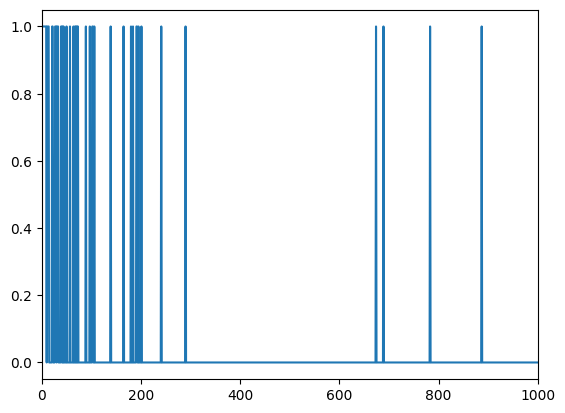

In [19]:
print("'binary' vectorized question:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

In [20]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [1011  784    9 2452    8 1862 2361  690 1265    4   40    5    1 1011
  196   12   74   13   72   33    2   98  104   14    3   70 9597    3
   34  888  202  784  107    8   41  242   40   58  291   90    3  196
  192   10    2  181    6  675    6   13   30 1187   12  784   22   43
    1   28    5  140   29 5207   15   29    1   28   51    1    1    1
    7   23   30    3  291   10   68    6   32   65  185  166  103   14
    2   65    6    1  193    9 2782   45 2407    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

As shown above, `TextVectorization`'s `'binary'` mode returns an array denoting which tokens exist at least once in the input, while the `'int'` mode replaces each token by an integer, thus preserving their order.

You can lookup the token (string) that each integer corresponds to by calling `TextVectorization.get_vocabulary` on the layer:

In [21]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  regex
313 --->  source
Vocabulary size: 10000


### Train the model

It's time to create your neural network.

For the `'binary'` vectorized data, define a simple bag-of-words linear model, then configure and train it:

In [22]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

tf.keras.utils.plot_model(binary_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [23]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10)

print()

Epoch 1/10
200/200 [==============================] - 5s 25ms/step - loss: 1.1161 - accuracy: 0.6525 - val_loss: 0.9126 - val_accuracy: 0.7788
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.7774 - accuracy: 0.8195 - val_loss: 0.7492 - val_accuracy: 0.7969
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6265 - accuracy: 0.8605 - val_loss: 0.6637 - val_accuracy: 0.8125
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5333 - accuracy: 0.8873 - val_loss: 0.6103 - val_accuracy: 0.8231
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4675 - accuracy: 0.9050 - val_loss: 0.5736 - val_accuracy: 0.8313
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.9167 - val_loss: 0.5470 - val_accuracy: 0.8350
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3771 - accuracy: 0.9292 - val_loss: 0.5269 - val_accuracy: 0.8369
Epoch

Next, you will use the `'int'` vectorized layer to build a 1D ConvNet:

In [24]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

In [25]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

tf.keras.utils.plot_model(int_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [26]:

int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 5s 25ms/step - loss: 1.2932 - accuracy: 0.3869 - val_loss: 0.9406 - val_accuracy: 0.6150
Epoch 2/10
200/200 [==============================] - 6s 28ms/step - loss: 0.7783 - accuracy: 0.6812 - val_loss: 0.6389 - val_accuracy: 0.7538
Epoch 3/10
200/200 [==============================] - 6s 29ms/step - loss: 0.5589 - accuracy: 0.7892 - val_loss: 0.5450 - val_accuracy: 0.7906
Epoch 4/10
200/200 [==============================] - 6s 31ms/step - loss: 0.4120 - accuracy: 0.8619 - val_loss: 0.4990 - val_accuracy: 0.8106
Epoch 5/10
200/200 [==============================] - 6s 30ms/step - loss: 0.2976 - accuracy: 0.9044 - val_loss: 0.4955 - val_accuracy: 0.8094
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.2178 - accuracy: 0.9353 - val_loss: 0.5105 - val_accuracy: 0.8069
Epoch 7/10
200/200 [==============================] - 6s 30ms/step - loss: 0.1539 - accuracy: 0.9591 - val_loss: 0.5414 - val_accuracy: 0.8069

Text(0, 0.5, 'CE/token')

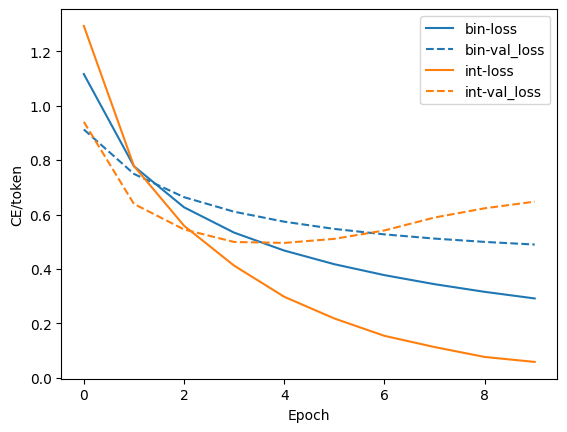

In [27]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

You are nearly ready to train your model.

As a final preprocessing step, you will apply the `TextVectorization` layers you created earlier to the training, validation, and test sets:

In [28]:
binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

### Export the model

In [31]:
binary_model.save('bin.tf')

INFO:tensorflow:Assets written to: bin.tf\assets


In [32]:
loaded = tf.saved_model.load('bin.tf')

In [33]:
binary_model.predict(['How do you sort a list?'])

1/1 [==============================] - 0s 112ms/step


array([[-0.07212637,  0.03263593, -0.6086115 ,  0.36667192]],
      dtype=float32)

In [ ]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

AttributeError: '_UserObject' object has no attribute 'predict'


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply `tf.keras.layers.TextVectorization`. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the `TextVectorization` layer inside your model when you're ready to prepare for deployment.

Visit the [Save and load models](../keras/save_and_load.ipynb) tutorial to learn more about saving models.

<a name="example2">

## Example 2: Predict the author of Iliad translations

The following provides an example of using `tf.data.TextLineDataset` to load examples from text files, and [TensorFlow Text](https://www.tensorflow.org/text) to preprocess the data. You will use three different English translations of the same work, Homer's Iliad, and train a model to identify the translator given a single line of text.

To implement this task you'll use some lower level tools.

* You'll use `tf.data.TextLineDataset` to load text-lines from files.
* You'll implement your own version of `keras.layers.TextVectorization` using:
  * `text.UnicodeScriptTokenizer` - to convert strings to tokens.
  * `tf.lookup.StaticVocabularyTable` - to convert tokens to integer ids.
* You'll maximize performance by placing the text processing in the dataset pipeline, so it can run in parallel with the model training.

### Download and explore the dataset

The texts of the three translations are by:

- [William Cowper](https://en.wikipedia.org/wiki/William_Cowper): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/cowper.txt)
- [Edward, Earl of Derby](https://en.wikipedia.org/wiki/Edward_Smith-Stanley,_14th_Earl_of_Derby): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/derby.txt)
- [Samuel Butler](https://en.wikipedia.org/wiki/Samuel_Butler_%28novelist%29): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/butler.txt)

The text files used in this tutorial have undergone some typical preprocessing tasks like removing document header and footer, line numbers and chapter titles.

Download these lightly munged files locally:

In [ ]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = utils.get_file(name, origin=DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

### Load the dataset

Previously, with `tf.keras.utils.text_dataset_from_directory` all contents of a file were treated as a single example. Here, you will use `tf.data.TextLineDataset`, which is designed to create a `tf.data.Dataset` from a text file where each example is a line of text from the original file. `TextLineDataset` is useful for text data that is primarily line-based (for example, poetry or error logs).

Iterate through these files, loading each one into its own dataset. Each example needs to be individually labeled, so use `Dataset.map` to apply a labeler function to each one. This will iterate over every example in the dataset, returning (`example, label`) pairs.

In [ ]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

In [ ]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

Next, you'll combine these labeled datasets into a single dataset using `Dataset.concatenate`, and shuffle it with `Dataset.shuffle`:


In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [ ]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

Print out a few examples as before. The dataset hasn't been batched yet, hence each entry in `all_labeled_data` corresponds to one data point:

In [ ]:
for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

### Prepare the dataset for training

Instead of using `tf.keras.layers.TextVectorization` to preprocess the text dataset, you will now use the lower-level TensorFlow Text APIs to standardize and tokenize the data, build a vocabulary and use `tf.lookup.StaticVocabularyTable` to map tokens to integers to feed to the model. (Learn more about [TensorFlow Text](https://www.tensorflow.org/text)).

Define a function to convert the text to lower-case and tokenize it:

- TensorFlow Text provides various tokenizers. In this example, you will use the `text.UnicodeScriptTokenizer` to tokenize the dataset.
- You will use `Dataset.map` to apply the tokenization to the dataset.

In [ ]:
class MyTokenizer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer()

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text)
    result = self.tokenizer.tokenize(lower_case)
    # If you pass a batch of strings, it will return a RaggedTensor.
    if isinstance(result, tf.RaggedTensor):
      # Convert to dense 0-padded.
      result = result.to_tensor()
    return result

In [ ]:
tokenizer = MyTokenizer()

In [ ]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

You can iterate over the dataset and print out a few tokenized examples:


In [ ]:
for tokens, label in tokenized_ds.take(1):
  break

print(tokens)
print()
print(label)

Next, you will build a vocabulary by sorting tokens by frequency and keeping the top `VOCAB_SIZE` tokens:

In [ ]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]

print("First five vocab entries:", vocab[:5])
print()

To convert the tokens into integers, use the `vocab` set to create a `tf.lookup.StaticVocabularyTable`. You will map tokens to integers with `0` reserved for padding, and `n+1` reserved to denote an out-of-vocabulary (OOV) token.

In [ ]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys = [''] + vocab
    self.values = range(len(self.keys))

    self.init = tf.lookup.KeyValueTensorInitializer(
        self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64)

    num_oov_buckets = 1

    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets)

  def call(self, x):
    result = self.table.lookup(x)
    return result

Try it on a dummy vocabulary:

In [ ]:
vocab_table = MyVocabTable(['a','b','c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

Create one for the real vocabulary:

In [ ]:
vocab_table = MyVocabTable(vocab)

Finally, define a layer to standardize, tokenize and vectorize the dataset using the tokenizer and lookup table:

In [ ]:
preprocess_text = tf.keras.Sequential([
    tokenizer,
    vocab_table
])

You can try this on a single example to print the output:

In [ ]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text = preprocess_text(example_text)
print("Vectorized sentence: ", vectorized_text.numpy())

Now create a dataset pipeline that will process the text on the fly using `Dataset.map`:

In [ ]:
all_encoded_data = all_labeled_data.map(lambda text, labels:(preprocess_text(text), labels))

for ids, label in all_encoded_data.take(1):
  break

print("Ids: ", ids.numpy())
print("Label: ", label.numpy())

### Split the dataset into training and test sets


The Keras `TextVectorization` layer also batches and pads the vectorized data. Padding is required because the examples inside of a batch need to be the same size and shape, but the examples in these datasets are not all the same size—each line of text has a different number of words.

`tf.data.Dataset` supports splitting and padded-batching datasets:

In [ ]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)

Now, `validation_data` and `train_data` are not collections of (`example, label`) pairs, but collections of batches. Each batch is a pair of (*many examples*, *many labels*) represented as arrays.

To illustrate this:

In [ ]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Configure the datasets for better performance as before:

In [ ]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

### Train the model

You can train a model on this dataset as before:

Since this text vectorization adds `0` for padding and `n+1` for out-of-vocabulary (OOV) tokens, the vocabulary size has increased by two:

In [ ]:
model = create_model(vocab_size=VOCAB_SIZE+2, num_labels=3)

model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(train_data, validation_data=validation_data, epochs=3)

In [ ]:
metrics = model.evaluate(validation_data, return_dict=True)

print("Loss: ", metrics['loss'])
print("Accuracy: {:2.2%}".format(metrics['accuracy']))

### Export the model

To make the model capable of taking raw strings as input, pack both the text processor and the model into a `keras.Sequential`:

In [ ]:
export_model = tf.keras.Sequential([
    preprocess_text,
    model
])

In [ ]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

This model you can run directly on batches of strings:

In [ ]:
# Create a test dataset of raw strings.
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds

In [ ]:
loss, accuracy = export_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

Use `saved_model.save` to export it.

<!-- TODO: After 2.15 switch this to use Model.export -->

In [ ]:
tf.saved_model.save(export_model, 'export.tf')

In [ ]:
loaded = tf.saved_model.load('export.tf')

In [ ]:
export_model(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

In [ ]:
loaded(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

The loss and accuracy for the model on encoded validation set and the exported model on the raw validation set are the same, as expected.

### Run inference on new data

In [ ]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

## Download more datasets using TensorFlow Datasets (TFDS)


You can download many more datasets from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview).

In this example, you will use the [IMDB Large Movie Review dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) to train a model for sentiment classification:

In [ ]:
# Training set.
train_ds = tfds.load(
    'imdb_reviews',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

In [ ]:
# Validation set.
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

Print a few examples:

In [ ]:
for review_batch, label_batch in val_ds.take(1):
  for i in range(5):
    print("Review: ", review_batch[i].numpy())
    print("Label: ", label_batch[i].numpy())

You can now preprocess the data and train a model as before.

Note: You will use `tf.keras.losses.BinaryCrossentropy` instead of `tf.keras.losses.SparseCategoricalCrossentropy` for your model, since this is a binary classification problem.

### Prepare the dataset for training

In [ ]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [ ]:
# Configure datasets for performance as before.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

### Create, configure and train the model

In [ ]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)
model.summary()

In [ ]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

In [ ]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

### Export the model

In [ ]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
]

predicted_scores = export_model.predict(inputs)
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

## Conclusion

This tutorial demonstrated several ways to load and preprocess text. As a next step, you can explore additional text preprocessing [TensorFlow Text](https://www.tensorflow.org/text) tutorials, such as:

- [BERT Preprocessing with TF Text](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)
- [Tokenizing with TF Text](https://www.tensorflow.org/text/guide/tokenizers)
- [Subword tokenizers](https://www.tensorflow.org/text/guide/subwords_tokenizer)

You can also find new datasets on [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). And, to learn more about `tf.data`, check out the guide on [building input pipelines](../../guide/data.ipynb).